![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [250]:
import warnings
warnings.filterwarnings('ignore')

In [251]:
# Importación de librerías
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score, f1_score
from sklearn import metrics


In [252]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [253]:
print(bikes.columns)


Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'total', 'hour'],
      dtype='object')


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [254]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [255]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

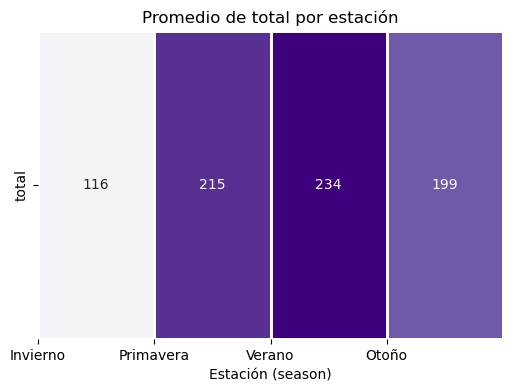

In [256]:
season_avg = bikes.groupby("season")["total"].mean().to_frame()
vmin, vmax = season_avg.min().values[0], season_avg.max().values[0]
plt.figure(figsize=(6, 4))
sns.heatmap(season_avg.T, annot=True, fmt=".0f", cmap="Purples", cbar=False, linewidths=1, vmin=season_avg.min().values[0] - 10 , vmax=vmax)
plt.title("Promedio de total por estación")
plt.xlabel("Estación (season)")
plt.ylabel("")
plt.xticks(ticks=[0, 1, 2, 3], labels=["Invierno", "Primavera", "Verano", "Otoño"])
plt.show()

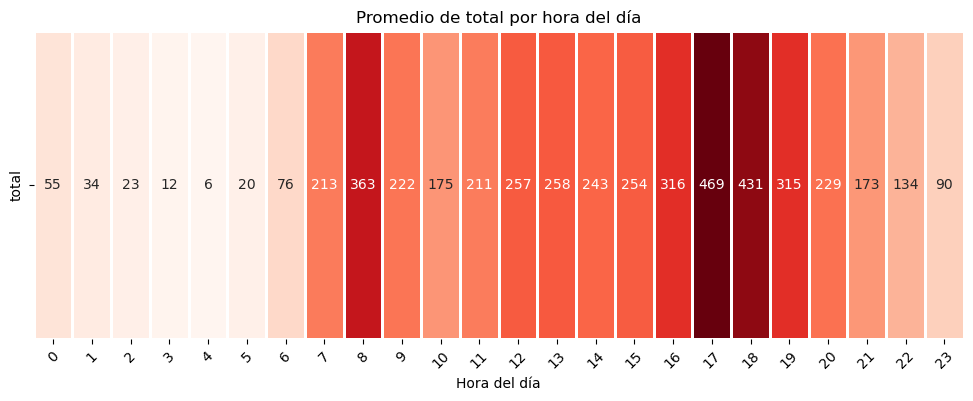

In [257]:
hour_avg = bikes.groupby("hour")["total"].mean().to_frame()
plt.figure(figsize=(12, 4))
sns.heatmap(hour_avg.T, annot=True, fmt=".0f", cmap="Reds", cbar=False, linewidths=1)
plt.title("Promedio de total por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("")
plt.xticks(rotation=45)
plt.show()

# Análisis descriptivo
## Hora del día
Para la columna Hour se tienen los valores de 0 a 23 horas. Se realizó un mapa de calor para poder inferir de manera más sencilla cuales son los picos de alquiler de bicicletas.
- Las horas con menos cantidad de bicicletas alquiladas es de las 11pm a las 5am, esto se debe a que es un espacio en el cual generalmente la gente descansa y la actividad económica también se mantiene en pausa en esta franja horaria
- Se reactiva a las 6 am, con un pico a las 8am, esto indica que la gente usa el transporte ya sea para ir a estudiar o al trabajo
- Posteriormente se vuelve a tener unas horas valle, pero con una cantidad aún así considerable de renta de bicicletas hasta las 4pm
- El pico máximo se tiene a la hora de volver a casa el cual es 5pm y 6pm respectivamente, este horario confirma que el uso que mayormente se le da al alquiler de bicicletas es para ir de casa al trabajo o estudio y viceversa. 
- Por ultimo empieza a disminuir paulativamente hasta las 10pm donde el servicio vuelve a quedar a la espera de una nueva jornada
## Estaciones del año 
En las estaciones del año se tienen 4 valores, los cuales respectivamente son "0 - Invierno", "1 - Primavera", "2 - Verano", "3 - Otoño". Se generó un mapa de calor para evidenciar el comportamiento de el alquiler de bicicletas
- La temporada 3(Verano) tiene el mayor uso de bicicletas con un total de 30.65%, esto porque es la temporada en la cuál hace el mejor clima para realizar actividades fisicas al aire libre
- Por otro lado, invierno obtuvo el menor valor con un 15.21% del total. Esto es una caida de la mitad respecto el verano, lo cual indica que la mitad de los usuarios prefieren usar otro tipo de transporte para estas fechas
- Primavera y otoño comparten valores intermedios, teniendo un 28% y 26% respectivamente. 


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

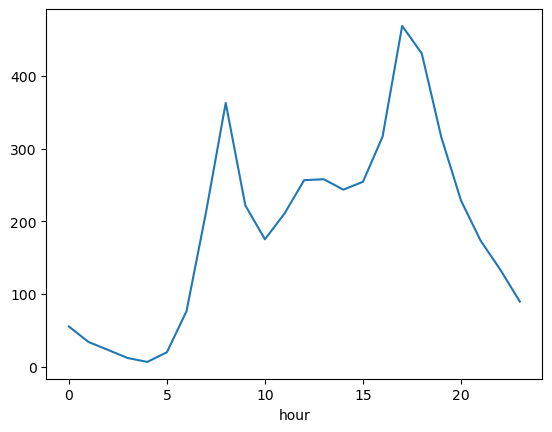

In [258]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

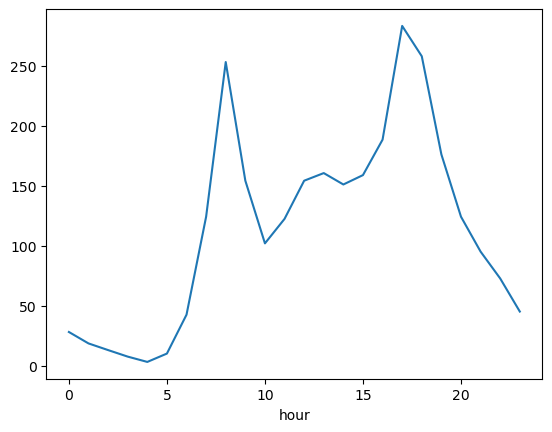

In [259]:
bikes_invierno = bikes[bikes['season'] == 1]
bikes_invierno.groupby('hour').total.mean().plot()


<Axes: xlabel='hour'>

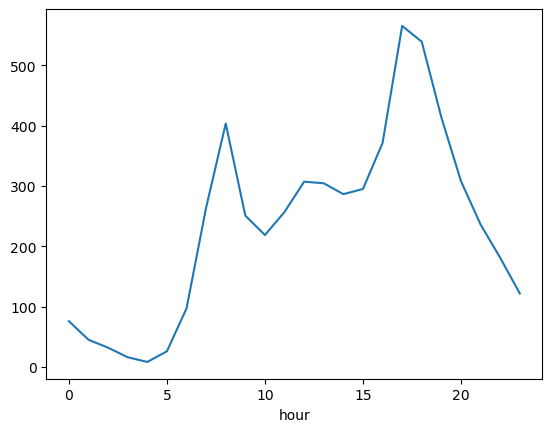

In [260]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes_verano = bikes[bikes['season'] == 3]
bikes_verano.groupby('hour').total.mean().plot()

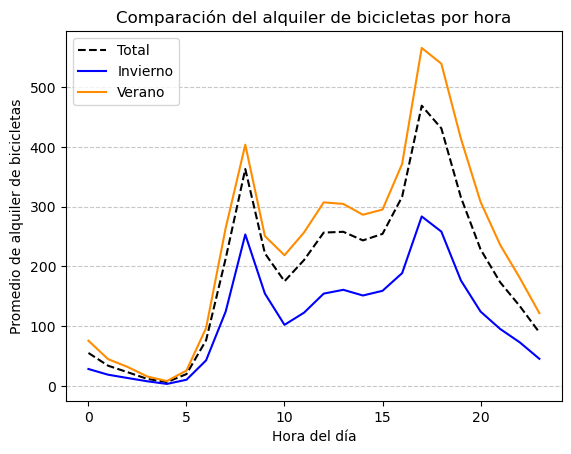

In [261]:
bikes.groupby('hour')['total'].mean().plot(label="Total", color="black", linestyle="dashed")
bikes_invierno.groupby('hour')['total'].mean().plot(label="Invierno", color="blue")
bikes_verano.groupby('hour')['total'].mean().plot(label="Verano", color="darkorange")
plt.xlabel("Hora del día")
plt.ylabel("Promedio de alquiler de bicicletas")
plt.title("Comparación del alquiler de bicicletas por hora")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend() 
plt.show()

# Análisis graficas
- El comportamiento de los datos muestra que sin importar la cantidad de bicicletas alquiladas la distribución a lo largo de las horas sigue siendo la misma. 
- En todas las estaciones se tiene como hora muerta las 5am y una reactivación a las 6am.
- En verano se tiene un mayor uso del alquiler de bicicletas, obteniendo un pico máximo de casi el doble en lo que respecta a invierno. Esto significa que la gente se encuentra mucho más dispuesta a usar la bicicleta como medio de transporte en esta temporada del año
- Aunque invierno sea la epoca del año más fria el alquiler de bicicletas sigue siendo un metodo de transporte que se usa con regularidad. 

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

Coeficientes del modelo: {'hour': 10.554487200290042, 'season': 26.93974051926176}
Intercepto: 2.1473084972571144
Error cuadrático medio: 26898.27
R²: 0.19


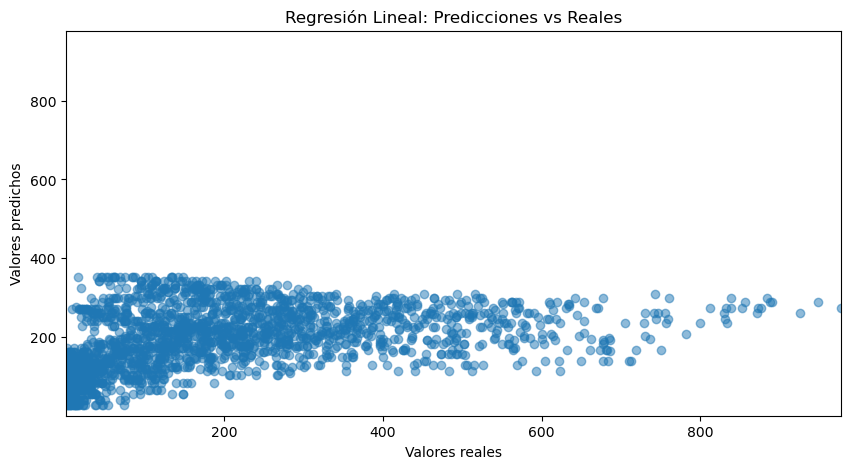

In [262]:
# Celda 3

# variables predictoras y objetivo
X = bikes[['hour', 'season']]
y = bikes['total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Coeficientes del modelo:", dict(zip(X.columns, model.coef_)))
print(f"Intercepto: {model.intercept_}")
print(f"Error cuadrático medio: {mse:.2f}")
print(f"R²: {r2:.2f}")

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Regresión Lineal: Predicciones vs Reales")

lim_min = min(y_test.min(), y_pred.min())
lim_max = max(y_test.max(), y_pred.max())

plt.xlim(lim_min, lim_max)
plt.ylim(lim_min, lim_max)

plt.show()

### Análisis regresión lineal
- En la variable hor, por cada aumento de unidad el valor de Total aumenta en 10.5, así mismo Season al ser categórica con 4 valores tiene un impacto mucho mayor, de 26.9. Esto explica que en este caso en particular la temporada es 2.6 veces más determinante que la hora. 
- Las limitaciones del modelo es que al ser solo dos variables es dificil que pueda predecir la variable total teniendo en cuenta que existen muchas más columnas que pueden tener también un impacto significativo en la variable de salida "Total", del mismo modo el R^2 es bajo, por lo cuál el modelo no captura del todo bien la relación de las variables

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [263]:
# Celda 4
# Definir variables predictoras y variable objetivo
X = bikes[['hour', 'season']]
y = bikes['total']

# Definir parámetros
max_depth = None
num_pct = 10
max_features = None
min_gain = 0.001

# Selección de una variable (hour en este caso)
j = 0  # Índice de la columna "hour"
print(X.columns[j])

# Obtener posibles puntos de corte
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)

# Selección de un punto de corte
k = 5
filter_l = X.iloc[:, j] < splits[k]

# División de la variable de respuesta
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

# Función para calcular el índice de Gini
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Calcular el índice de Gini
gini_l = gini(y_l)
gini_r = gini(y_r)

# Función para calcular la impureza de Gini
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)

    return gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)

# Calcular la ganancia de la variable "hour"
gini_impurity(X.iloc[:, j], y, splits[k])

# Función para encontrar la mejor división
def best_split(X, y, num_pct=10):
    best_split = [0, 0, 0]  # j, split, gain

    for j in range(X.shape[1]):
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct + 1)).tolist())
        splits = np.unique(splits)[1:]

        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

# Encontrar la mejor variable y punto de corte
j, split, gain = best_split(X, y, 5)

# División de las observaciones
filter_l = X.iloc[:, j] < split
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

# Función para construir el árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    if X.shape[0] == 1:
        return dict(y_pred=y.iloc[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)

    j, split, gain = best_split(X, y, num_pct)

    y_pred = int(y.mean() >= 0.5)
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)

    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)

    if gain < min_gain or (max_depth is not None and level >= max_depth):
        return tree

    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain, max_depth, num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain, max_depth, num_pct)

    return tree

# Construcción del árbol
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10)

# Función para hacer predicciones con el árbol
def tree_predict(X, tree, proba=False):
    predicted = np.ones(X.shape[0])

    if tree['split'] == -1:
        return predicted * (tree['y_prob'] if proba else tree['y_pred'])

    j, split = tree['split']
    filter_l = X.iloc[:, j] < split
    X_l = X.loc[filter_l]
    X_r = X.loc[~filter_l]

    if X_l.shape[0] == 0:
        predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
    elif X_r.shape[0] == 0:
        predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
    else:
        predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

hour


In [264]:
# Aplicar predicciones
tree

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'gain': 7207.700659959655,
  'sl': {'y_pred': 1,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'gain': 646.8008927589567,
   'sl': {'y_pred': 1,
    'y_prob': 25.15934475055845,
    'level': 3,
    'split': [0, 2.0],
    'n_samples': 2684,
    'gain': 382.8088308604629,
    'sl': {'y_pred': 1,
     'y_prob': 44.41383095499451,
     'level': 4,
     'split': [1, 2.0],
     'n_samples': 909,
     'gain': 291.4004681825131,
     'sl': {'y_pred': 1,
      'y_prob': 23.32456140350877,
      'level': 5,
      'split': [0, 1.0],
      'n_samples': 226,
      'gain': 45.41972746495435,
      'sl': {'y_pred': 1,
       'y_prob': 27.808695652173913,
       'level': 6,
       'split': -1,
       'n_samples': 113,
 

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

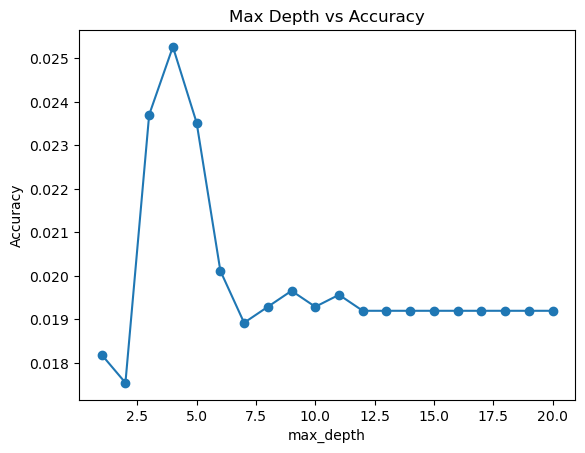

Mejor max_depth: 4 con Accuracy: 0.0253


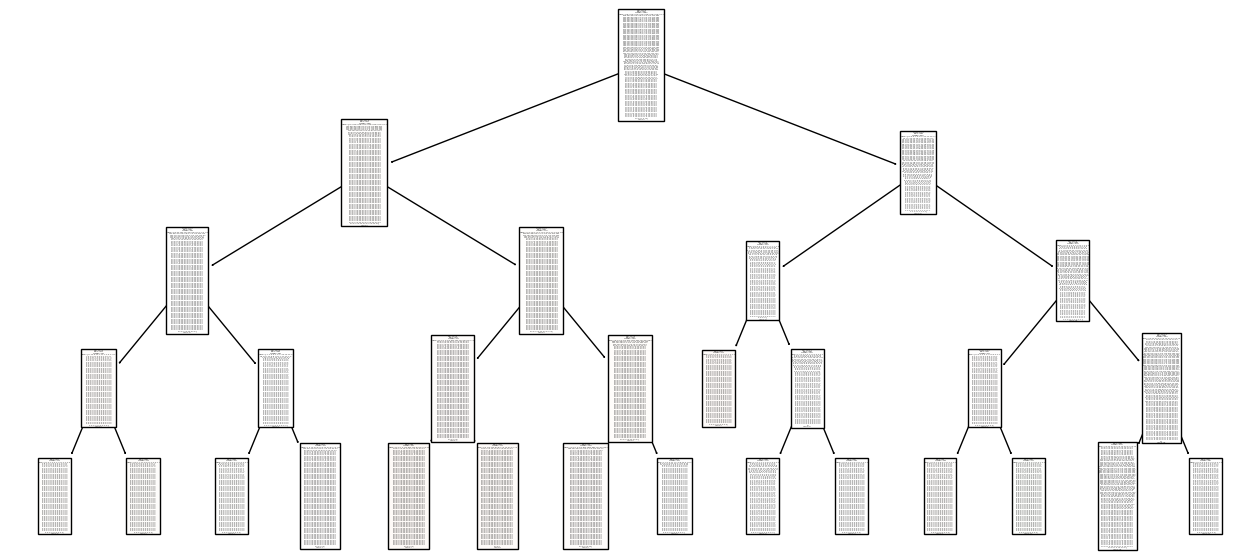

In [265]:
# Celda 5

max_depth_range = range(1, 21)
accuracy_scores = []
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())
    mse_scores = -cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error').mean()
# Gráfica max_depth versus Accuracy
plt.plot(max_depth_range, accuracy_scores, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Max Depth vs Accuracy')
plt.show()
best_depth, best_accuracy = sorted(zip(max_depth_range, accuracy_scores), key=lambda x: x[1], reverse=True)[0]
print(f'Mejor max_depth: {best_depth} con Accuracy: {best_accuracy:.4f}')

# Ajuste del modelo con la mejor profundidad encontrada
clf = DecisionTreeClassifier(max_depth=best_depth, random_state=1)
clf.fit(X, y)

# Grafico del arbol
class_names = [str(cls) for cls in np.unique(y)]
plt.figure(figsize=(16, 7))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=class_names)
plt.show()


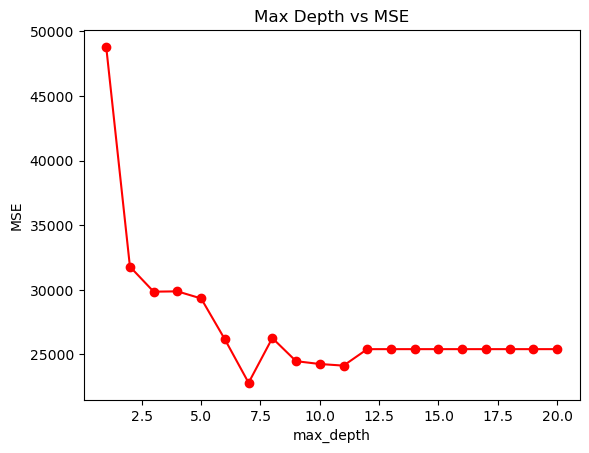

Mejor max_depth: 7 con MSE mínimo: 22789.5130


In [266]:
mse_scores = [] 
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    mse_scores.append(-cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error').mean())

# Graficar max_depth vs MSE
plt.plot(max_depth_range, mse_scores, marker='o', color='red')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.title('Max Depth vs MSE')
plt.show()
min_mse = min(mse_scores)
best_depth = max_depth_range[mse_scores.index(min_mse)]
print(f"Mejor max_depth: {best_depth} con MSE mínimo: {min_mse:.4f}")


### Desempeño del modelo 
Se obtuvo que el mejor max_depth para tener un accuracy alto fue de 4, con un valor de 0.0253. Sin embargo, este sigue siendo un valor bajo, por lo cual, se buscó disminuir el MSE para tener una comparación respecto al punto 3. En este caso en particular, se obtuvo el mejor max_depth de 7, con un MSE de 22789.5, a diferencia de la regresión lineal del punto 3, que obtuvo un MSE de 26898. Esto representa una mejora del 15.28%, lo que muestra que el árbol de decisión se ajusta mejor que la regresión lineal para predecir "Y" a partir de "X".

# Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [267]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [268]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [269]:
# División de la muestra en set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [270]:
# Celda 6
# modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000, random_state=1)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# modelo de Árbol de Decisión
tree_clf = DecisionTreeClassifier(max_depth=1, random_state=1) 
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

# Evaluación
acc_log = accuracy_score(y_test, y_pred_log)
acc_tree = accuracy_score(y_test, y_pred_tree)

# Crear DataFrame con Accuracy y F1-score
results = pd.DataFrame({
    "Métrica": ["Accuracy", "F1-score"],
    "Regresión Logística": [acc_log, f1_score(y_test, y_pred_log)],
    "Árbol de Decisión": [acc_tree, f1_score(y_test, y_pred_tree)]
})

# Mostrar tabla
print(results.round(4))

    Métrica  Regresión Logística  Árbol de Decisión
0  Accuracy               0.6147             0.6453
1  F1-score               0.6025             0.6449


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

## Arbol clasificador con max depth =5

In [271]:
# Celda 7
# Definir número de modelos
n_estimators = 100

# Semillas aleatorias para reproducibilidad
np.random.seed(123)
seeds = np.random.randint(1, 10000, size=n_estimators)
# Diccionario para almacenar los modelos
trees = {}

for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_depth=5, random_state=seeds[i])
    trees[i].fit(X, y)  # Entrenar el modelo

# Crear un DataFrame para almacenar las predicciones de cada modelo
y_pred_df = pd.DataFrame(index=X.index, columns=list(range(n_estimators)))

# Obtener predicciones de los 100 modelos
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X)


In [272]:
# Ajustar los índices de y_pred_df para que coincidan con X_test
y_pred_df = y_pred_df.loc[X_test.index]  # Solo mantener las filas correspondientes a X_test
# Votación mayoritaria: Si más de la mitad de los modelos predicen "1", el resultado final es "1"
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int64)

# Evaluación del desempeño del ensamble con F1-Score y Accuracy
f1 = metrics.f1_score(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

# Mostrar resultados
print(f"F1-Score del Ensamble(Max depth=5): {f1:.4f}")
print(f"Accuracy del Ensamble(Max depth=5): {accuracy:.4f}")

F1-Score del Ensamble(Max depth=5): 0.6752
Accuracy del Ensamble(Max depth=5): 0.6800


## Arbol clasificador con min samples leaf = 100

In [273]:
# Definir número de modelos
n_estimators = 100

# Semillas aleatorias para reproducibilidad
np.random.seed(123)
seeds = np.random.randint(1, 10000, size=n_estimators)

# Diccionario para almacenar los modelos
trees = {}

# Entrenar 100 modelos de Árbol de Decisión con min_samples_leaf=100
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(min_samples_leaf=100, random_state=seeds[i])
    trees[i].fit(X, y)  # Entrenar el modelo

# Crear un DataFrame para almacenar las predicciones de cada modelo
y_pred_leaf_df = pd.DataFrame(index=X.index, columns=list(range(n_estimators)))

# Obtener predicciones de los 100 modelos
for i in range(n_estimators):
    y_pred_leaf_df.iloc[:, i] = trees[i].predict(X)

# Mostrar las primeras filas de las predicciones
y_pred_leaf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [274]:
# Ajustar los índices de y_pred_leaf_df para que coincidan con X_test
y_pred_leaf_df = y_pred_leaf_df.loc[X_test.index]  # Solo mantener las filas correspondientes a X_test
# Votación mayoritaria: Si más de la mitad de los modelos predicen "1", el resultado final es "1"
y_pred_leaf = (y_pred_leaf_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int64)

# Evaluación del desempeño del ensamble con F1-Score y Accuracy
f1_leaf = metrics.f1_score(y_test, y_pred_leaf)
accuracy_leaf = metrics.accuracy_score(y_test, y_pred_leaf)

# Mostrar resultados
print(f"F1-Score del Ensamble (min_samples_leaf=100): {f1_leaf:.4f}")
print(f"Accuracy del Ensamble (min_samples_leaf=100): {accuracy_leaf:.4f}")


F1-Score del Ensamble (min_samples_leaf=100): 0.6931
Accuracy del Ensamble (min_samples_leaf=100): 0.6900


## Regresion logística 

In [275]:
# Definir número de modelos
n_estimators = 100

# Semillas aleatorias para reproducibilidad
np.random.seed(123)
seeds = np.random.randint(1, 10000, size=n_estimators)

# Diccionario para almacenar los modelos
logistic_models = {}

# Entrenar 100 modelos de Regresión Logística
for i in range(n_estimators):
    logistic_models[i] = LogisticRegression(random_state=seeds[i], max_iter=1000)
    logistic_models[i].fit(X, y)  # Entrenar el modelo

# Crear un DataFrame para almacenar las predicciones de cada modelo
y_pred_log_df = pd.DataFrame(index=X.index, columns=list(range(n_estimators)))

# Obtener predicciones de los 100 modelos
for i in range(n_estimators):
    y_pred_log_df.iloc[:, i] = logistic_models[i].predict(X)

# Mostrar las primeras filas de las predicciones
y_pred_log_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [276]:
# Ajustar los índices de y_pred_log_df para que coincidan con X_test
y_pred_log_df = y_pred_log_df.loc[X_test.index]  # Solo mantener las filas correspondientes a X_test


# Votación mayoritaria: Si más de la mitad de los modelos predicen "1", el resultado final es "1"
y_pred_log = (y_pred_log_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int64)

# Evaluación del desempeño del ensamble con F1-Score y Accuracy
f1_log = metrics.f1_score(y_test, y_pred_log)
accuracy_log = metrics.accuracy_score(y_test, y_pred_log)

# Mostrar resultados
print(f"F1-Score del Ensamble (Regresión Logística): {f1_log:.4f}")
print(f"Accuracy del Ensamble (Regresión Logística): {accuracy_log:.4f}")

F1-Score del Ensamble (Regresión Logística): 0.6136
Accuracy del Ensamble (Regresión Logística): 0.6247


## Ensamblaje

In [277]:
# Combinar las predicciones de los 3 ensambles en un solo DataFrame
y_pred_ensemble_df = pd.concat([y_pred_df, y_pred_leaf_df, y_pred_log_df], axis=1)

# Asegurar que los índices coincidan con X_test
y_pred_ensemble_df = y_pred_ensemble_df.loc[X_test.index]

# Aplicar votación mayoritaria sobre las 300 predicciones
y_pred_ensemble = (y_pred_ensemble_df.sum(axis=1) >= (y_pred_ensemble_df.shape[1] / 2)).astype(np.int64)

# Evaluar desempeño del ensamble final
f1_ensemble = metrics.f1_score(y_test, y_pred_ensemble)
accuracy_ensemble = metrics.accuracy_score(y_test, y_pred_ensemble)

# Mostrar resultados
print(f"F1-Score del Ensamble Final: {f1_ensemble:.4f}")
print(f"Accuracy del Ensamble Final: {accuracy_ensemble:.4f}")


F1-Score del Ensamble Final: 0.6739
Accuracy del Ensamble Final: 0.6793


## Evaluación de modelos punto 7

### Modelo Árbol de decisión con max_depth = 5
- **F1-Score del Ensamble** (max_depth=5): 0.6752
- **Accuracy del Ensamble** (max_depth=5): 0.6800

### Modelo Árbol de decisión con min_samples_leaf = 100
- **F1-Score del Ensamble** (min_samples_leaf=100): 0.6931
- **Accuracy del Ensamble** (min_samples_leaf=100): 0.6900

### Modelo de regresión logística
- **F1-Score del Ensamble** (Regresión Logística): 0.6136
- **Accuracy del Ensamble** (Regresión Logística): 0.6247

### Ensamblaje final
- **F1-Score del Ensamble Final**: 0.6739
- **Accuracy del Ensamble Final**: 0.6793

### Análisis y recomendaciones
En base a los valores de las metricas obtenidas los mejores 100 modelos fueron los del **arbol de decisión con min samples leaf igual a 100**, estos obtuvieron el valor más alto, mientras que el modelo de regresión logistica fue el que obtuvo los valores más bajos de los 300 modelos. Esto repercute negativamente al momento de hacer el ensamblaje final, pues disminuyó el poder predictivo del total de modelos.

Para mejorar el ensamblaje, se podría:
1. Explorar otros modelos distintos a la regresión logística, que puedan aportar mayor precisión.
2. Validar si es posible que exista algún sesgo dentro de la muestra que se uso para predecir el modelo, puede que esto lo afecte negativamente


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [278]:
# Celda 8
clf_tree_path = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5),  
                                  n_estimators=100, bootstrap=True, 
                                  random_state=42, n_jobs=-1, oob_score=True)

# Entrenamiento del modelo
clf_tree_path.fit(X_train, y_train)

# Cálculo de pesos alpha basados en error OOB
errors = np.zeros(clf_tree_path.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf_tree_path.n_estimators))

for i in range(clf_tree_path.n_estimators):
    oob_sample = ~clf_tree_path.estimators_samples_[i]
    y_pred_ = clf_tree_path.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf_tree_path.estimators_[i].predict(X_test)

# Cálculo de los pesos
alpha = (1 - errors) / (1 - errors).sum()

# Votación ponderada
y_pred_tree_depth = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int64)

# Evaluación con votación ponderada
f1_tree_depth = metrics.f1_score(y_test, y_pred_tree_depth)
accuracy_tree_depth = metrics.accuracy_score(y_test, y_pred_tree_depth)

# Mostrar resultados
print(f"F1-Score con votación ponderada (max depth=5): {f1_tree_depth:.4f}")
print(f"Accuracy con votación ponderada (max depth=5): {accuracy_tree_depth:.4f}")

F1-Score con votación ponderada (max depth=5): 0.6495
Accuracy con votación ponderada (max depth=5): 0.6553


In [279]:
# Definir el modelo con min_samples_leaf=100
clf_tree_leaf = BaggingClassifier(estimator=DecisionTreeClassifier(min_samples_leaf=100),  
                                  n_estimators=100, bootstrap=True, 
                                  random_state=42, n_jobs=-1, oob_score=True)

# Entrenamiento del modelo
clf_tree_leaf.fit(X_train, y_train)

# Cálculo de pesos alpha basados en error OOB
errors = np.zeros(clf_tree_leaf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf_tree_leaf.n_estimators))

for i in range(clf_tree_leaf.n_estimators):
    oob_sample = ~clf_tree_leaf.estimators_samples_[i]
    y_pred_ = clf_tree_leaf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf_tree_leaf.estimators_[i].predict(X_test)

# Cálculo de los pesos
alpha = (1 - errors) / (1 - errors).sum()

# Votación ponderada
y_pred_tree_leaf = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int64)

# Evaluación con votación ponderada
f1_tree_leaf = metrics.f1_score(y_test, y_pred_tree_leaf)
accuracy_tree_leaf = metrics.accuracy_score(y_test, y_pred_tree_leaf)

# Mostrar resultados
print(f"F1-Score con votación ponderada (min_samples_leaf=100): {f1_tree_leaf:.4f}")
print(f"Accuracy con votación ponderada (min_samples_leaf=100): {accuracy_tree_leaf:.4f}")

F1-Score con votación ponderada (min_samples_leaf=100): 0.6626
Accuracy con votación ponderada (min_samples_leaf=100): 0.6653


In [280]:
# Definir el modelo de Regresión Logística con Bagging
clf_logistic = BaggingClassifier(estimator=LogisticRegression(max_iter=1000),  
                                 n_estimators=100, bootstrap=True, 
                                 random_state=42, n_jobs=-1, oob_score=True)

# Entrenamiento del modelo
clf_logistic.fit(X_train, y_train)

# Cálculo de pesos alpha basados en error OOB
errors = np.zeros(clf_logistic.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf_logistic.n_estimators))

for i in range(clf_logistic.n_estimators):
    oob_sample = ~clf_logistic.estimators_samples_[i]
    y_pred_ = clf_logistic.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf_logistic.estimators_[i].predict(X_test)

# Cálculo de los pesos
alpha = (1 - errors) / (1 - errors).sum()

# Votación ponderada
y_pred_logistic = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int64)

# Evaluación con votación ponderada
f1_logistic = metrics.f1_score(y_test, y_pred_logistic)
accuracy_logistic = metrics.accuracy_score(y_test, y_pred_logistic)

# Mostrar resultados
print(f"F1-Score con votación ponderada (Regresión Logística): {f1_logistic:.4f}")
print(f"Accuracy con votación ponderada (Regresión Logística): {accuracy_logistic:.4f}")


F1-Score con votación ponderada (Regresión Logística): 0.6030
Accuracy con votación ponderada (Regresión Logística): 0.6147


In [281]:
# Obtener probabilidades de predicción en lugar de etiquetas
prob_tree_depth = clf_tree_path.predict_proba(X_test)[:, 1]
prob_tree_leaf = clf_tree_leaf.predict_proba(X_test)[:, 1]
prob_logistic = clf_logistic.predict_proba(X_test)[:, 1]

# Calcular pesos de los modelos (normalizados con F1-Score)
total_f1 = f1_tree_depth + f1_tree_leaf + f1_logistic
weight_tree_depth = f1_tree_depth / total_f1
weight_tree_leaf = f1_tree_leaf / total_f1
weight_logistic = f1_logistic / total_f1

# Combinar predicciones ponderadas usando probabilidades
y_pred_ensemble_prob = (weight_tree_depth * prob_tree_depth +
                        weight_tree_leaf * prob_tree_leaf +
                        weight_logistic * prob_logistic)

# Convertir a clase final (umbral 0.5)
y_pred_ensemble = (y_pred_ensemble_prob >= 0.5).astype(np.int64)

# Evaluar desempeño del ensamblaje
f1_ensemble = metrics.f1_score(y_test, y_pred_ensemble)
accuracy_ensemble = metrics.accuracy_score(y_test, y_pred_ensemble)

print(f"F1-Score del Ensamblaje: {f1_ensemble:.4f}")
print(f"Accuracy del Ensamblaje: {accuracy_ensemble:.4f}")

F1-Score del Ensamblaje: 0.6536
Accuracy del Ensamblaje: 0.6580


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.


| **Modelo**                          | **Votación Mayoritaria**       | **Votación Ponderada**        |
|-------------------------------------|--------------------------------|--------------------------------|
| Árbol de Decisión (max_depth=5)     | F1-Score: 0.6752              | F1-Score: 0.6495              |
|                                     | Accuracy: 0.6800              | Accuracy: 0.6553              |
| Árbol de Decisión (min_samples_leaf=100) | F1-Score: 0.6931              | F1-Score: 0.6626              |
|                                     | Accuracy: 0.6900              | Accuracy: 0.6653              |
| Regresión Logística                 | F1-Score: 0.6136              | F1-Score: 0.6030              |
|                                     | Accuracy: 0.6247              | Accuracy: 0.6147              |
| **Ensamblaje Final**                | F1-Score: 0.6739              | F1-Score: 0.6536              |
|                                     | Accuracy: 0.6793              | Accuracy: 0.6580              |

- Para el primer caso donde max depth es 5 se muestra que votación mayoritaria maneja mejor las predicciones del modelo. Del mismo modo sucede para min samples leaf igual a 100 y por ultimo en la regresión logistica también votación mayoritaria tiene tanto un f1-score como un accuracy mucho mejor. 
- Los resultados anteriores muestran que votación mayoritaria tiene mejores resultados para los modelos,  por lo cual es más eficaz que ponderar. 
- De forma individual el mejor modelo que se obtuvo fue el arbol de decisión on min samples leaf igual a 100.  
- Por ultimo, como se mencionó en el punto 7, el ensamblaje mejora los valores respecto la regresion logistica pero no supera el desempeño individual. Por lo cual se podría para futuros trabajos probar un modelo distinto o probar con nuevos parametros.